# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model （暂时不用跑）

We first download an image from the COCO dataset:

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:03, 48.0MB/s]                           
/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

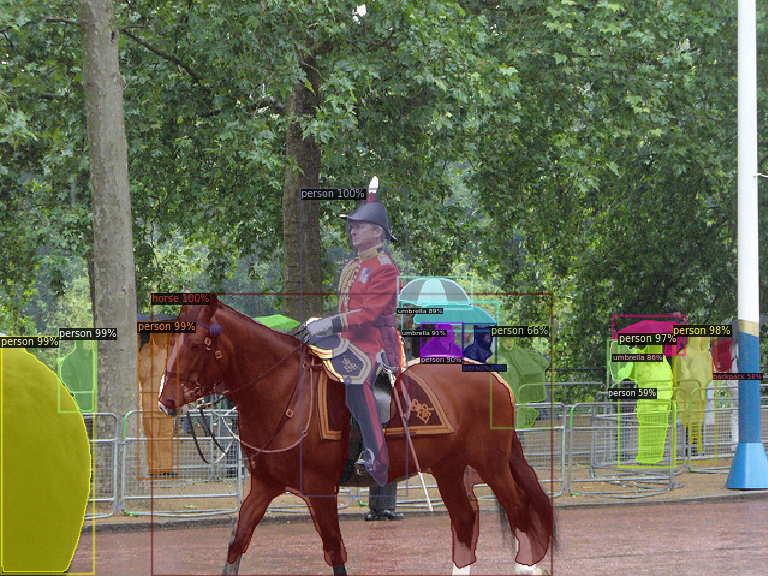

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the balloon segmentation dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)
which only has one class: balloon.
We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [ ]:
# download, decompress the data
#!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
#!unzip balloon_dataset.zip > /dev/null

Register the balloon dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.


## Upload coco_train and coco_test dataset respectively and unzip

In [ ]:
!unzip COCO7-train.zip -d /content/train
!unzip COCO7-test.zip -d /content/test

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/result.json", "/content/train")
register_coco_instances("my_dataset_test", {}, "/content/test/result.json", "/content/test")

# Dont use this chunk unless you are not using COCO file （用上一个chunk就可以）

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

#To verify the dataset is in correct format, let's visualize the annotations of randomly selected samples in the training set:



WARNING [11/01 03:13:14 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/01 03:13:14 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/Detect_train/result.json


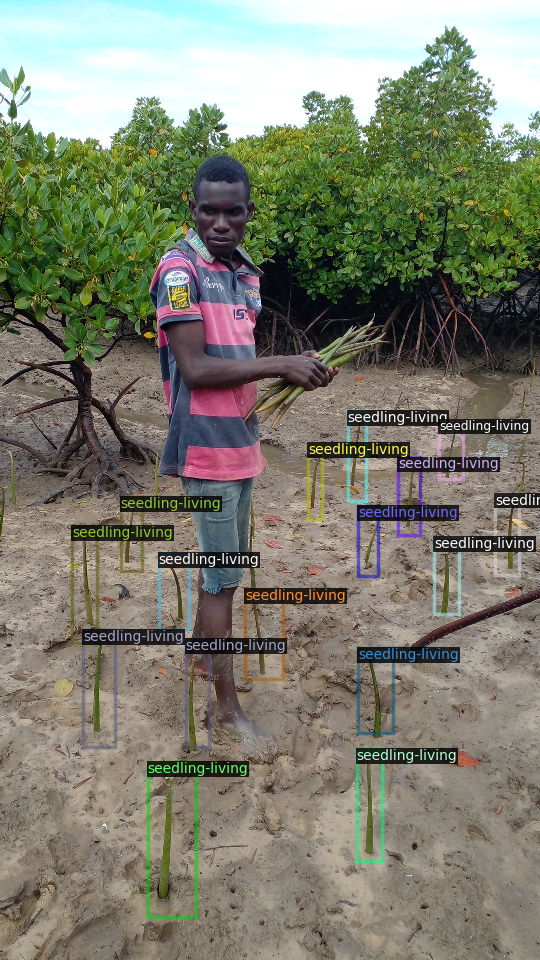

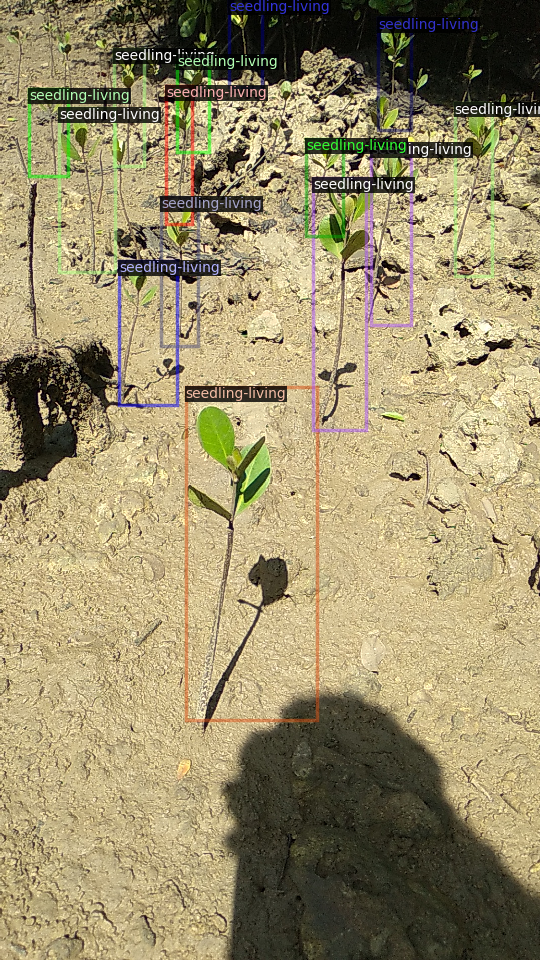

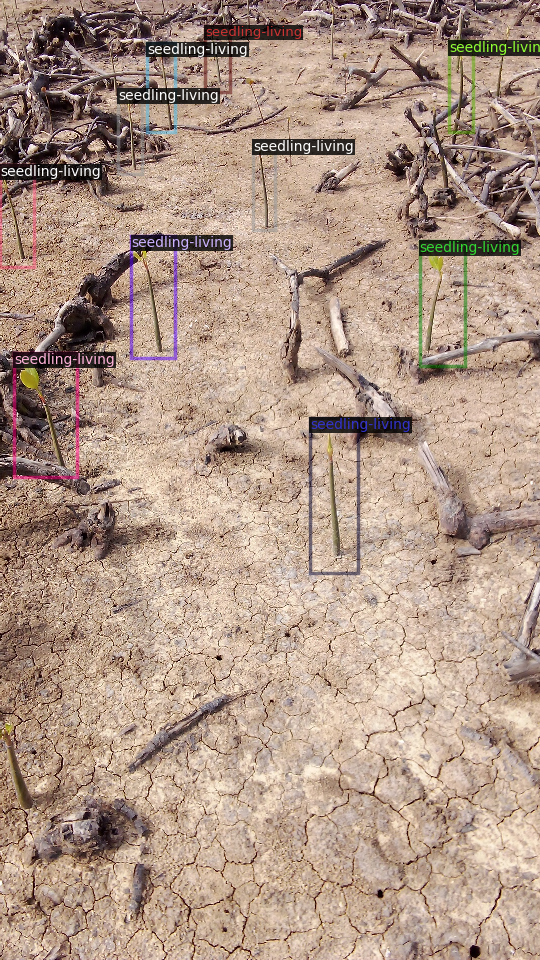

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.


In [6]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/02 01:43:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_298dad.pkl: 212MB [00:01, 115MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/02 01:43:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ERROR [11/02 01:43:39 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/content/detectron2/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/content/detectron2/detectron2/engine/defaults.py", line 496, in run_step
    self._trainer.run_step()
  File "/content/detectron2/detectron2/engine/train_loop.py", line 297, in run_step
    data = next(self._data_loader_iter)
  File "/content/detectron2/detectron2/data/common.py", line 329, in __iter__
    for d in self.dataset:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1345, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1371, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.10/dist-packages/to

SizeMismatchError: ignored

In [ ]:
file_name = "/content/train/images/83a7a065-06-03-2023___002.696Q.jpg"
img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
print (img.shape[:2])

from PIL import Image, ImageOps
from fvcore.common.file_io import PathManager
with PathManager.open(file_name, "rb") as f:
  image = Image.open(f)
  image = ImageOps.exif_transpose(image)
  image = np.asarray(image)
  print (image.shape[:2])

(1080, 1920)
(1920, 1080)


In [ ]:
import shutil

# Specify the folder path
folder_path = '/content/output'

# Use shutil.rmtree to remove the folder and its contents
shutil.rmtree(folder_path)


In [ ]:
from PIL import Image, JpegImagePlugin

def remove_exif(image_path, output_path):
    try:
        image = Image.open(image_path)
        if hasattr(image, '_getexif'):
            image = JpegImagePlugin.Exif(image)
            image.save(output_path)
        else:
            image.save(output_path)
        print(f"EXIF information removed and saved to {output_path}")
    except (AttributeError, KeyError, IndexError):
        print(f"Failed to remove EXIF information for {image_path}")

image_directory = '/content/Detect_train/images'  # Replace with your image directory
output_directory = '/content/Detect_train/images_no_exif'  # Replace with the directory to save images with EXIF removed

os.makedirs(output_directory, exist_ok=True)

for filename in os.listdir(image_directory):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
        input_path = os.path.join(image_directory, filename)
        output_path = os.path.join(output_directory, filename)
        remove_exif(input_path, output_path)


Failed to remove EXIF information for /content/Detect_train/images/c2eb72c5-03-08-2023___018.AhtW.jpg
Failed to remove EXIF information for /content/Detect_train/images/684cc03b-31-03-2023___007.o0T2.jpg
Failed to remove EXIF information for /content/Detect_train/images/aa4c3e55-01-11-2022___085.jpg
Failed to remove EXIF information for /content/Detect_train/images/434f5519-16-08-2023___022.x55q.jpg
Failed to remove EXIF information for /content/Detect_train/images/2e919800-29-06-2023___007.Bj1c.jpg
Failed to remove EXIF information for /content/Detect_train/images/c17f5b63-28-07-2023___009.nFw6.jpg
Failed to remove EXIF information for /content/Detect_train/images/89eedc10-23-05-2023___003.BQPS.jpg
Failed to remove EXIF information for /content/Detect_train/images/5aaf19e9-11-08-2023___005.63AL.jpg
Failed to remove EXIF information for /content/Detect_train/images/397096cb-03-05-2023___005.knB5.jpg
Failed to remove EXIF information for /content/Detect_train/images/00513bc7-01-11-2022_

In [4]:
import os
from PIL import Image

image_directory = '/content/train/images'

def has_exif_info(image_path):

    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        return hasattr(img, '_getexif')
    except (AttributeError, KeyError, IndexError):
        return False

image_files = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

for image_file in image_files:
    if has_exif_info(image_file):
        print(f"EXIF info found for {image_file}")
    else:
        print(f"No EXIF info for {image_file}")


EXIF info found for /content/train/images/397096cb-03-05-2023___005.knB5.jpg
EXIF info found for /content/train/images/d4c697dd-22-05-2023___013.kkaz.jpg
EXIF info found for /content/train/images/434f5519-16-08-2023___022.x55q.jpg
EXIF info found for /content/train/images/8edcc968-25-04-2023___004.KVsc.jpg
EXIF info found for /content/train/images/59a83079-15-06-2023___063._fuP.jpg
EXIF info found for /content/train/images/d100f8ec-18-05-2023___001.Bo1u.jpg
EXIF info found for /content/train/images/c9a0a4b8-02-08-2023___006.xkry.jpg
EXIF info found for /content/train/images/aa4c3e55-01-11-2022___085.jpg
EXIF info found for /content/train/images/28527711-11-08-2023___008.Msg-.jpg
EXIF info found for /content/train/images/d5dc0a03-01-11-2022___021.jpg
EXIF info found for /content/train/images/5bd02117-10-08-2023___014.PIU-.jpg
EXIF info found for /content/train/images/100175d3-30-08-2023___017.3CJx.jpg
EXIF info found for /content/train/images/c2eb72c5-03-08-2023___018.AhtW.jpg
EXIF info

In [6]:
import os

def has_exif(image_path):
    try:
        # Open the image file in binary mode
        with open(image_path, 'rb') as file:
            data = file.read(12)  # Read the first 12 bytes of the file

            # Check for the EXIF header
            if data[0:4] == b'Exif' and data[6:12] == b'\x00\x00\x00\x00\x00\x00':
                return True
    except Exception as e:
        print(f"Error while checking EXIF for {image_path}: {str(e)}")

    return False

image_directory = '/content/train/images'  # Replace with your image directory

for filename in os.listdir(image_directory):
    if filename.lower().endswith(('.jpg', '.jpeg')):
        image_path = os.path.join(image_directory, filename)
        if has_exif(image_path):
            print(f"{filename} has EXIF information.")
        else:
            print(f"{filename} does not have EXIF information.")


397096cb-03-05-2023___005.knB5.jpg does not have EXIF information.
d4c697dd-22-05-2023___013.kkaz.jpg does not have EXIF information.
434f5519-16-08-2023___022.x55q.jpg does not have EXIF information.
8edcc968-25-04-2023___004.KVsc.jpg does not have EXIF information.
59a83079-15-06-2023___063._fuP.jpg does not have EXIF information.
d100f8ec-18-05-2023___001.Bo1u.jpg does not have EXIF information.
c9a0a4b8-02-08-2023___006.xkry.jpg does not have EXIF information.
aa4c3e55-01-11-2022___085.jpg does not have EXIF information.
28527711-11-08-2023___008.Msg-.jpg does not have EXIF information.
d5dc0a03-01-11-2022___021.jpg does not have EXIF information.
5bd02117-10-08-2023___014.PIU-.jpg does not have EXIF information.
100175d3-30-08-2023___017.3CJx.jpg does not have EXIF information.
c2eb72c5-03-08-2023___018.AhtW.jpg does not have EXIF information.
7b91249b-11-07-2023___014.Xb0T.jpg does not have EXIF information.
2e919800-29-06-2023___007.Bj1c.jpg does not have EXIF information.
2c624

In [ ]:
import shutil

# Define the source file path
source_file = '/content/c2eb72c5-03-08-2023___018.AhtW.jpg'

# Define the destination folder path
destination_folder = '/content/Detect_train/images'

# Move the file to the destination folder
shutil.move(source_file, destination_folder)


'/content/Detect_train/images/c2eb72c5-03-08-2023___018.AhtW.jpg'

In [ ]:
d = DatasetCatalog.get('my_dataset_train')
print(d[0]['width'])
print(d[0]['height'])

WARNING [10/31 20:56:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/31 20:56:15 d2.data.datasets.coco]: Loaded 50 images in COCO format from /content/Detect_train/result.json
1920
1080


In [ ]:
d[0]

In [ ]:
from PIL import Image
im = Image.open(d[0]["file_name"],mode=)
width, height = im.size
print(width, height)

1080 1920


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

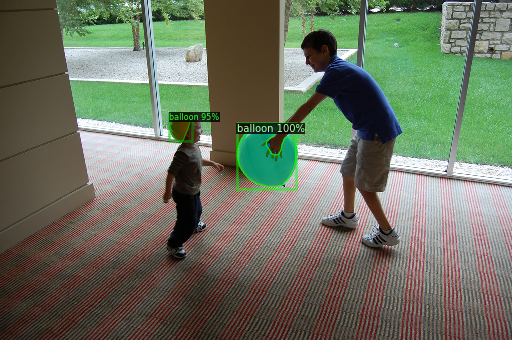

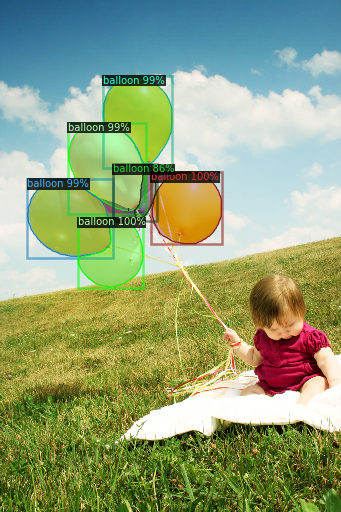

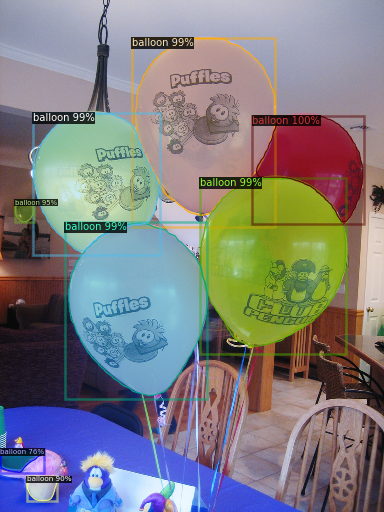

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70. Not bad!

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[09/02 02:45:11 d2.evaluation.coco_evaluation]: 'balloon_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[09/02 02:45:11 d2.data.datasets.coco]: Converting annotations of dataset 'balloon_val' to COCO format ...)
[09/02 02:45:11 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[09/02 02:45:11 d2.data.datasets.coco]: Conversion finished, #images: 13, #annotations: 50
[09/02 02:45:11 d2.data.datasets.coco]: Caching COCO format annotations at './output/balloon_val_coco_format.json' ...
[09/02 02:45:12 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[09/02 02:45:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/02 02:45:12 d2.data.common]: Serializing 13 elements to

# Other types of builtin models

We showcase simple demos of other types of models below:

WARNING [10/15 06:33:32 d2.config.compat]: Config './detectron2_repo/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


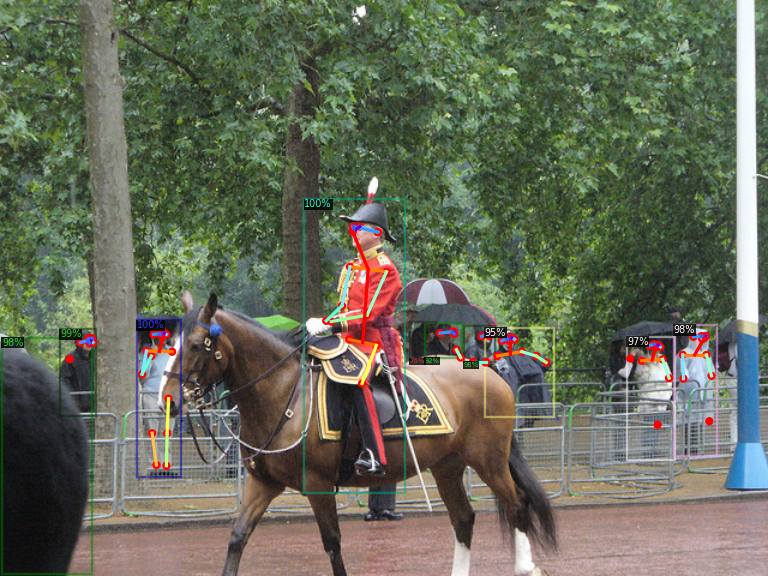

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

WARNING [10/15 06:33:37 d2.config.compat]: Config './detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


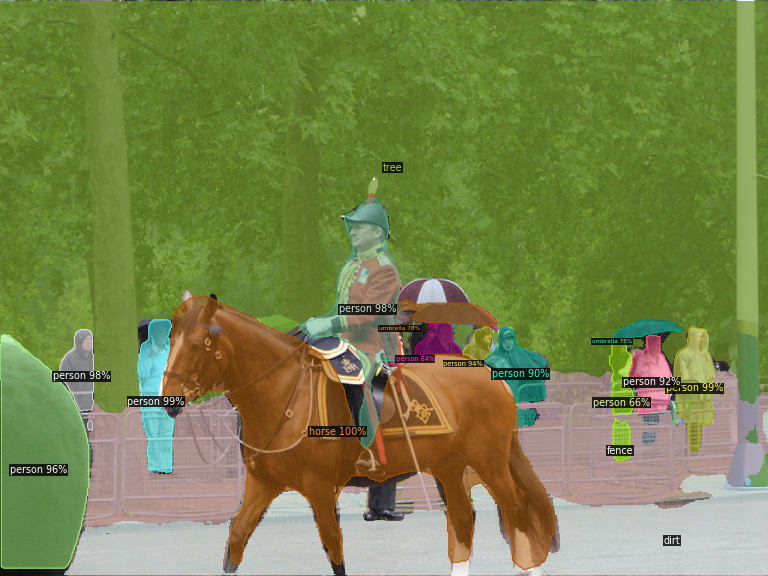

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

# Run panoptic segmentation on a video

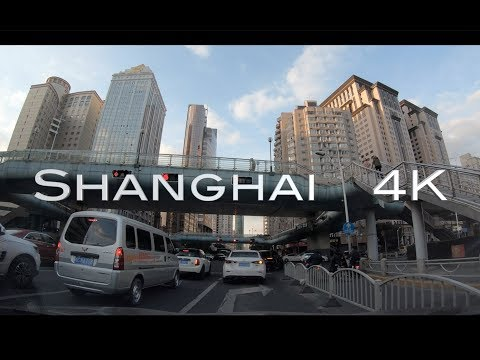

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [ ]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')